In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

#dBu = 20log10(V/0.775V)
#The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.

def rffts(y, y_err): #the imput are 2d arrays bc this function computes multiple ffts
    #window = get_window("hanning", y.shape[1])
    window = np.ones(y.shape[1])
    print(window.shape)
    print(y.shape)

    y_windowed = y* window[np.newaxis, :]
    y_err_windowed = y_err * window[np.newaxis, :]
    print(y_windowed.shape)

    N = len(y)
    print(N)
    #print(x_windowed)
    Y = fft.rfft(y_windowed, axis = 1)
    Y_normalized = np.abs(Y)
    #print(X_normalized)
    #Y_dBu = 20*(np.log10(np.abs(Y_normalized) *0.001 / 0.775) )
    Y_dBu = Y_normalized
    
    Y_err = fft.rfft(y_err_windowed, axis = 1)
    Y_err_normalized = np.abs(Y_err) / N
    Y_err_dBu = 20*(Y_err_normalized) / (np.log(10) * Y_normalized)
    
    return Y_dBu, Y_err_dBu

def mean_fft(all_magnitudes, all_errors):
    means = np.mean(all_magnitudes, axis = 0) #weights are all the same
    stat_stds = np.std(all_magnitudes, axis = 0)
    weights = 1/all_errors**2
    syst_stds = 1/weights.sum(axis = 0)
    return means, np.sqrt(stat_stds**2 + syst_stds**2)

In [79]:
hour = '12.14'
day = '29072024'

# stack all wfs

In [80]:
file_pattern_wfs = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list = []


if not file_list_wfs:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wfs):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
            amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)

0                (ms)
1          0.00000000
2          0.00100480
3          0.00200960
4          0.00301440
             ...     
99522     99.99869776
99523     99.99970256
99524    100.00070736
99525    100.00171216
99526    100.00271696
Name: Time, Length: 99527, dtype: object
0                 (mV)
1        -114.17320000
2        -122.04720000
3        -118.11020000
4        -118.11020000
             ...      
99522    -114.17320000
99523    -122.04720000
99524    -118.11020000
99525    -118.11020000
99526    -114.17320000
Name: Channel A, Length: 99527, dtype: object


# error on amplitudes

In [81]:
conversion_factor = 0.001

LSB = 1/256 #1V / (2**8) = voltage range / number of levels 
error = (0.5)*LSB
amplitude_errors = np.full(all_amplitudes.shape, error)


# compute ffts of all wfs and average those

In [82]:
Y_dBu, Y_err_dBu = rffts(all_amplitudes, amplitude_errors)
magnitudes_avg, magnitudes_avg_errors = mean_fft(Y_dBu, Y_err_dBu)

(99526,)
(64, 99526)
(64, 99526)
64


f_s = 995.2329599185722


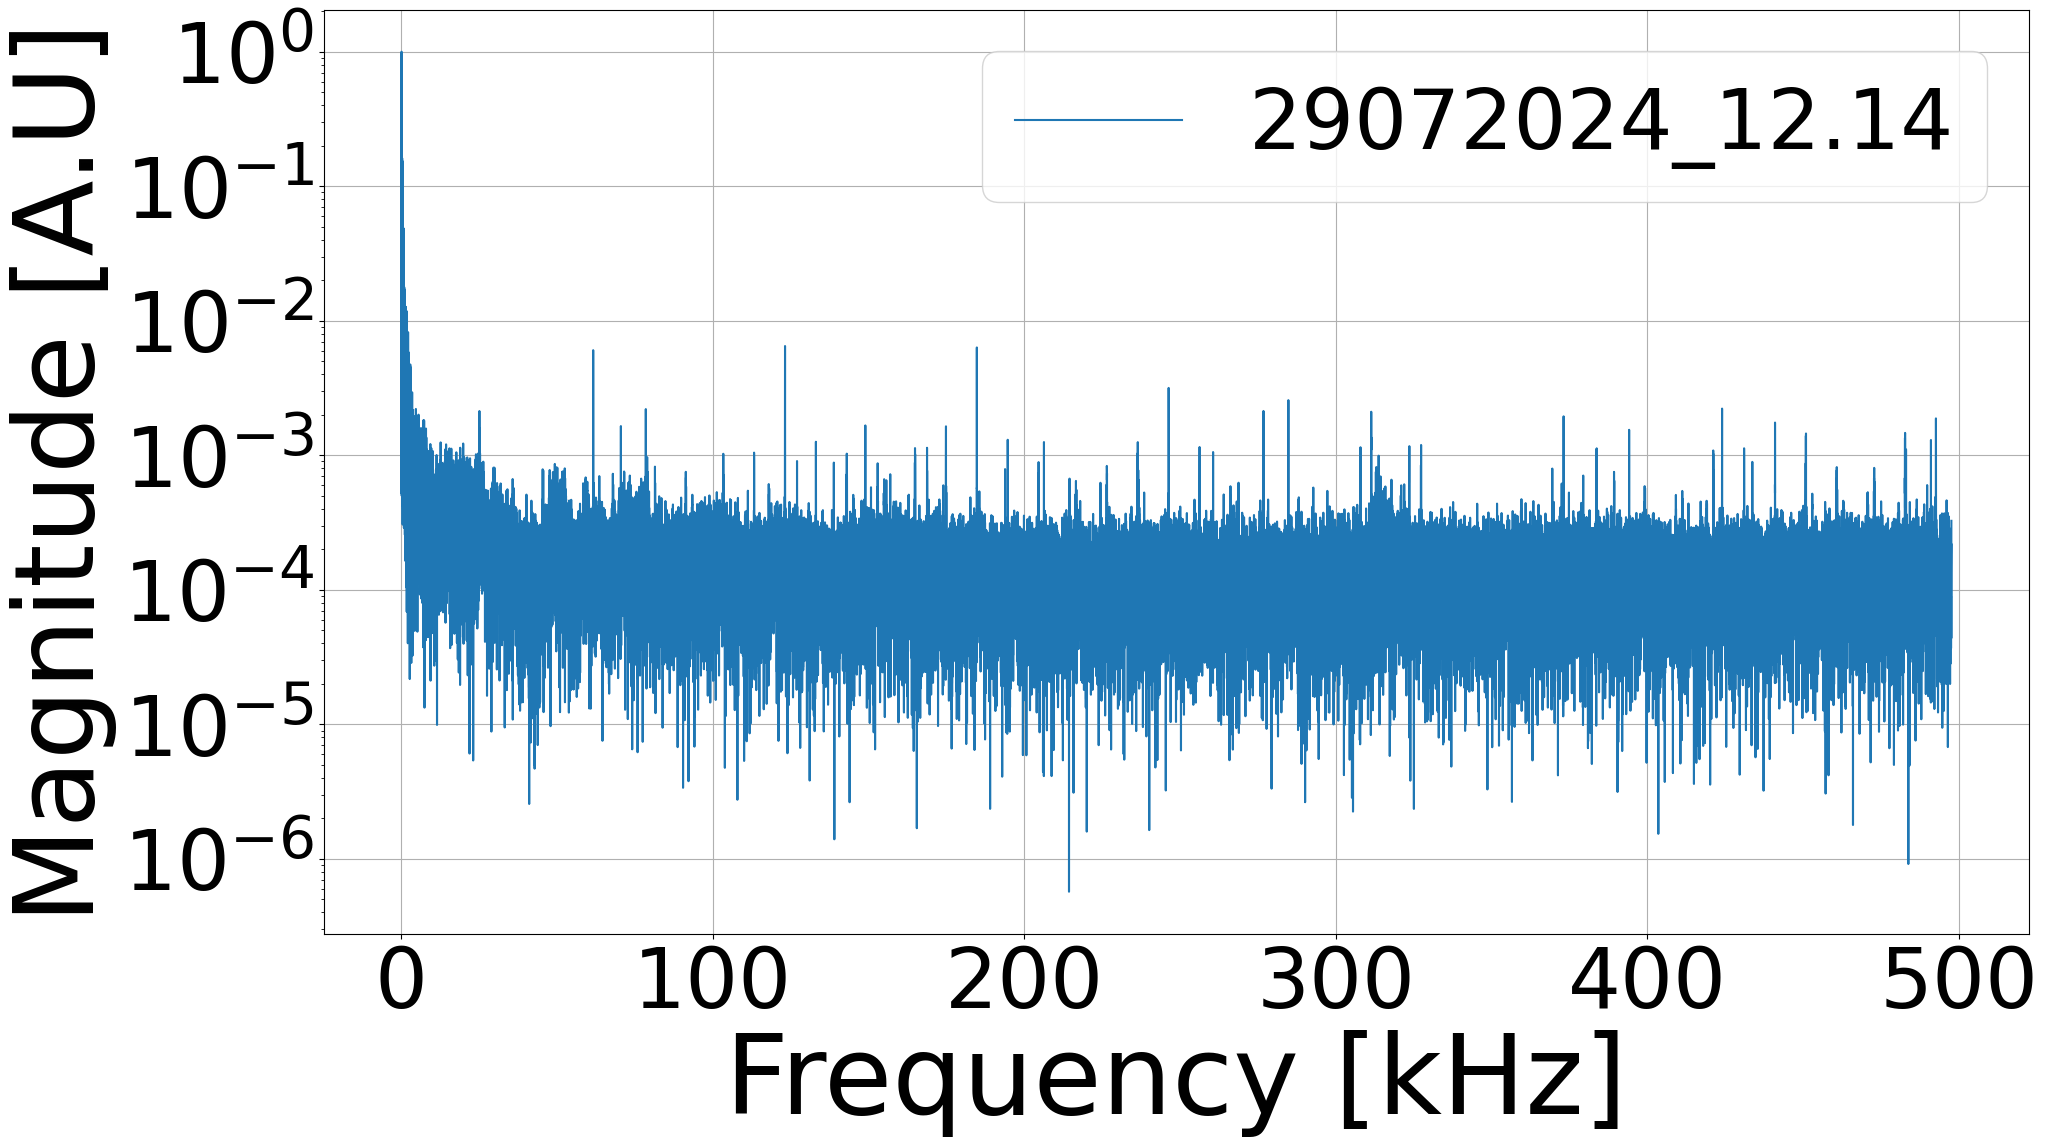

In [83]:
span = times[len(times)-1] 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.rfftfreq(all_amplitudes.shape[1], 1/f_s) #window lenght, sample spacing


plt.figure(figsize=(22, 12))
#plt.errorbar(freqs, magnitudes_avg, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, magnitudes_avg/max(magnitudes_avg), label = f'{day}_{hour}')
plt.title('', fontsize = 80)
plt.xlabel('Frequency [kHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.legend(fontsize = 60)
plt.semilogy()

#plt.savefig("../Results/290724_12.14/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


# Comparison with GUI

In [84]:
file_pattern_ffts = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_fft.csv/{day}_{hour}_fft_*.csv"
file_list_ffts = glob.glob(file_pattern_ffts)

magnitudes_list = []

for i, file in enumerate(file_list_ffts):
    df = pd.read_csv(file)
    if i == 0:
        print(df.iloc[:, 0])
        print(df.iloc[:, 1])
        freqs_GUI = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        magnitudes_GUI = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
    magnitudes_list.append(magnitudes_GUI)
    
print(magnitudes_list)
all_magnitudes = np.stack(magnitudes_list, axis = 0)
N = all_magnitudes.shape[1]

LSB = 1/256 #1V / (2**8) = voltage range / number of levels 
error = (0.5) * LSB
magnitude_errors_GUI = np.full(all_magnitudes.shape, error)

magnitude_errors_GUI = fft.fft(magnitude_errors_GUI, axis = 1)
magnitude_errors_GUI = 20* np.abs(magnitude_errors_GUI)/(N*np.log(10)*all_magnitudes)

magnitudes_avg_GUI, magnitude_avg_errors_GUI = mean_fft(all_magnitudes, magnitude_errors_GUI)

0               (kHz)
1          0.00000000
2          0.03037179
3          0.06074359
4          0.09111538
             ...     
16380    497.45960978
16381    497.48998158
16382    497.52035337
16383    497.55072516
16384    497.58109696
Name: Frequency, Length: 16385, dtype: object
0               (dBu)
1        -26.24694000
2        -20.90971000
3        -19.98840000
4        -29.66409000
             ...     
16380    -88.32677000
16381    -92.70543000
16382    -93.34309000
16383    -89.13463000
16384    -93.65471000
Name: Channel A, Length: 16385, dtype: object
[array([-26.24694, -20.90971, -19.9884 , ..., -93.34309, -89.13463,
       -93.65471]), array([-26.24694, -20.90971, -19.9884 , ..., -93.34309, -89.13463,
       -93.65471]), array([-26.24694, -20.90971, -19.9884 , ..., -93.34309, -89.13463,
       -93.65471]), array([-26.24694, -20.90971, -19.9884 , ..., -93.34309, -89.13463,
       -93.65471]), array([-26.24694, -20.90971, -19.9884 , ..., -93.34309, -89.13463,
       -

C:\Users\giuly\AppData\Local\Temp\ipykernel_2888\1939269724.py:41: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1/all_errors**2


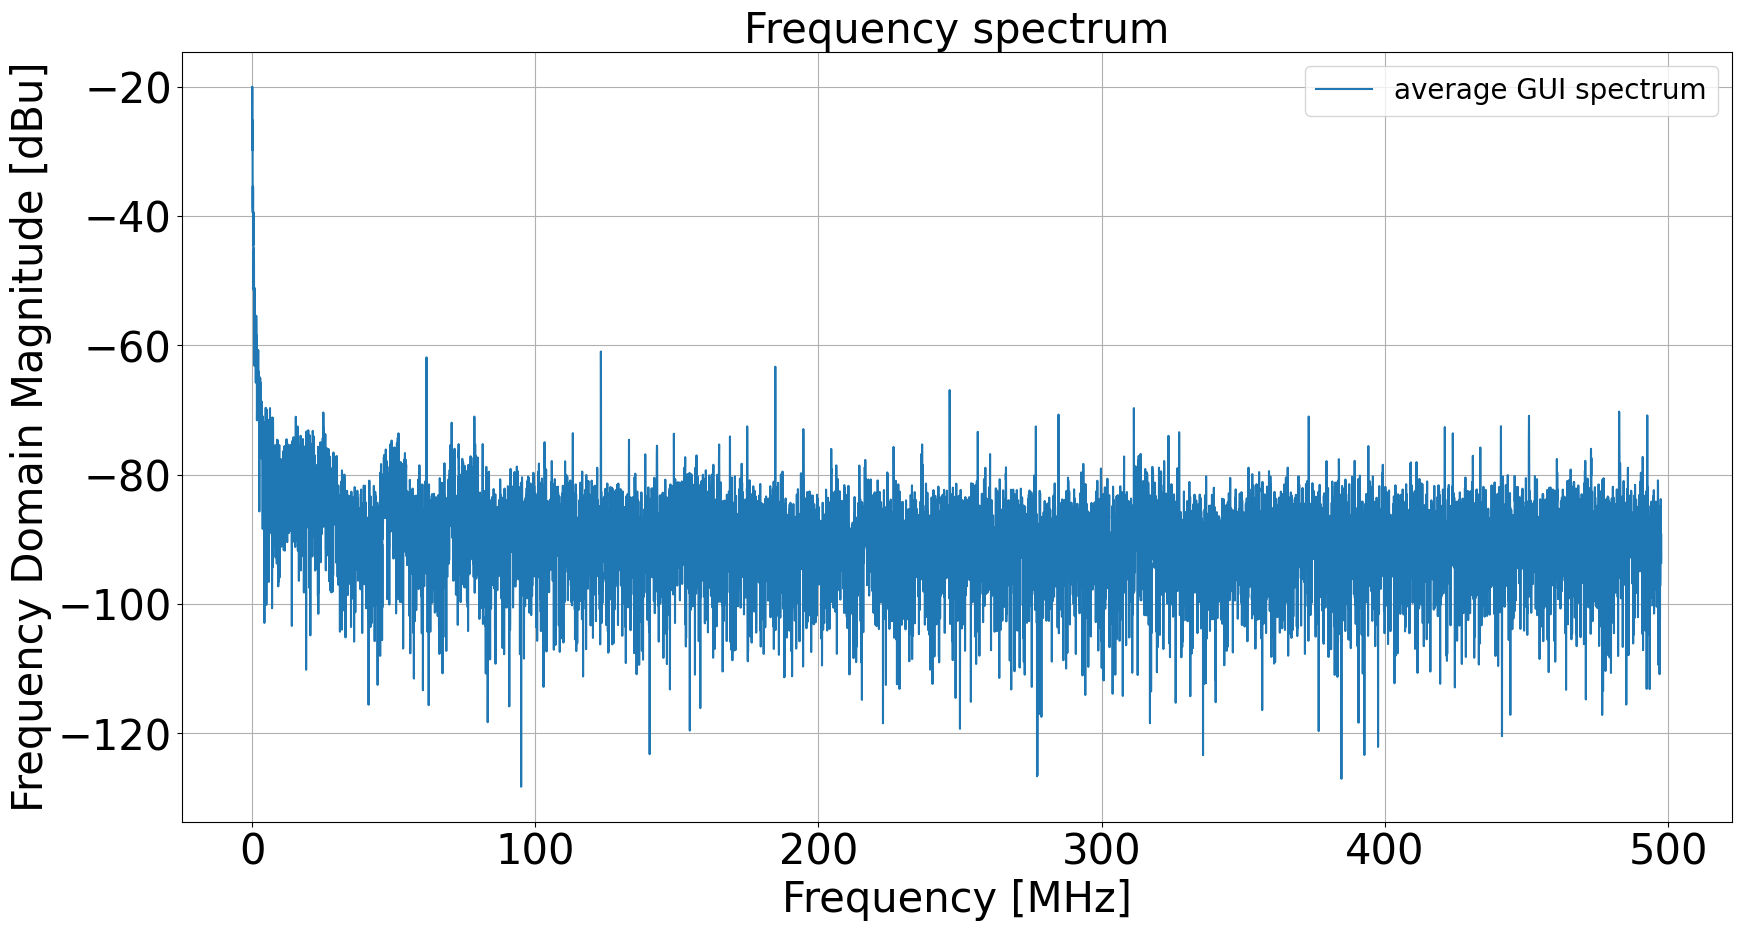

In [85]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, magnitudes, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
#plt.plot(freqs[freqs <= 350], magnitudes_avg[freqs <= 350], label = 'average fft')
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#-----------------------------------------------------------------------------

#plt.errorbar(freqs, magnitudes, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_GUI, magnitudes_avg_GUI, label = 'average GUI spectrum')
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [86]:
offset_blue = np.mean(magnitudes_avg[(freqs >= 250) & (freqs <= 350)])
offset_orange = np.mean(magnitudes_avg_GUI[(freqs_GUI >= 250) & (freqs_GUI <= 350)])
print(f"offset blue: {offset_blue} - offset orange: {offset_orange} = {offset_blue - offset_orange}")
diff = offset_blue - offset_orange

offset blue: 887.6461723648619 - offset orange: -90.37383078979344 = 978.0200031546553


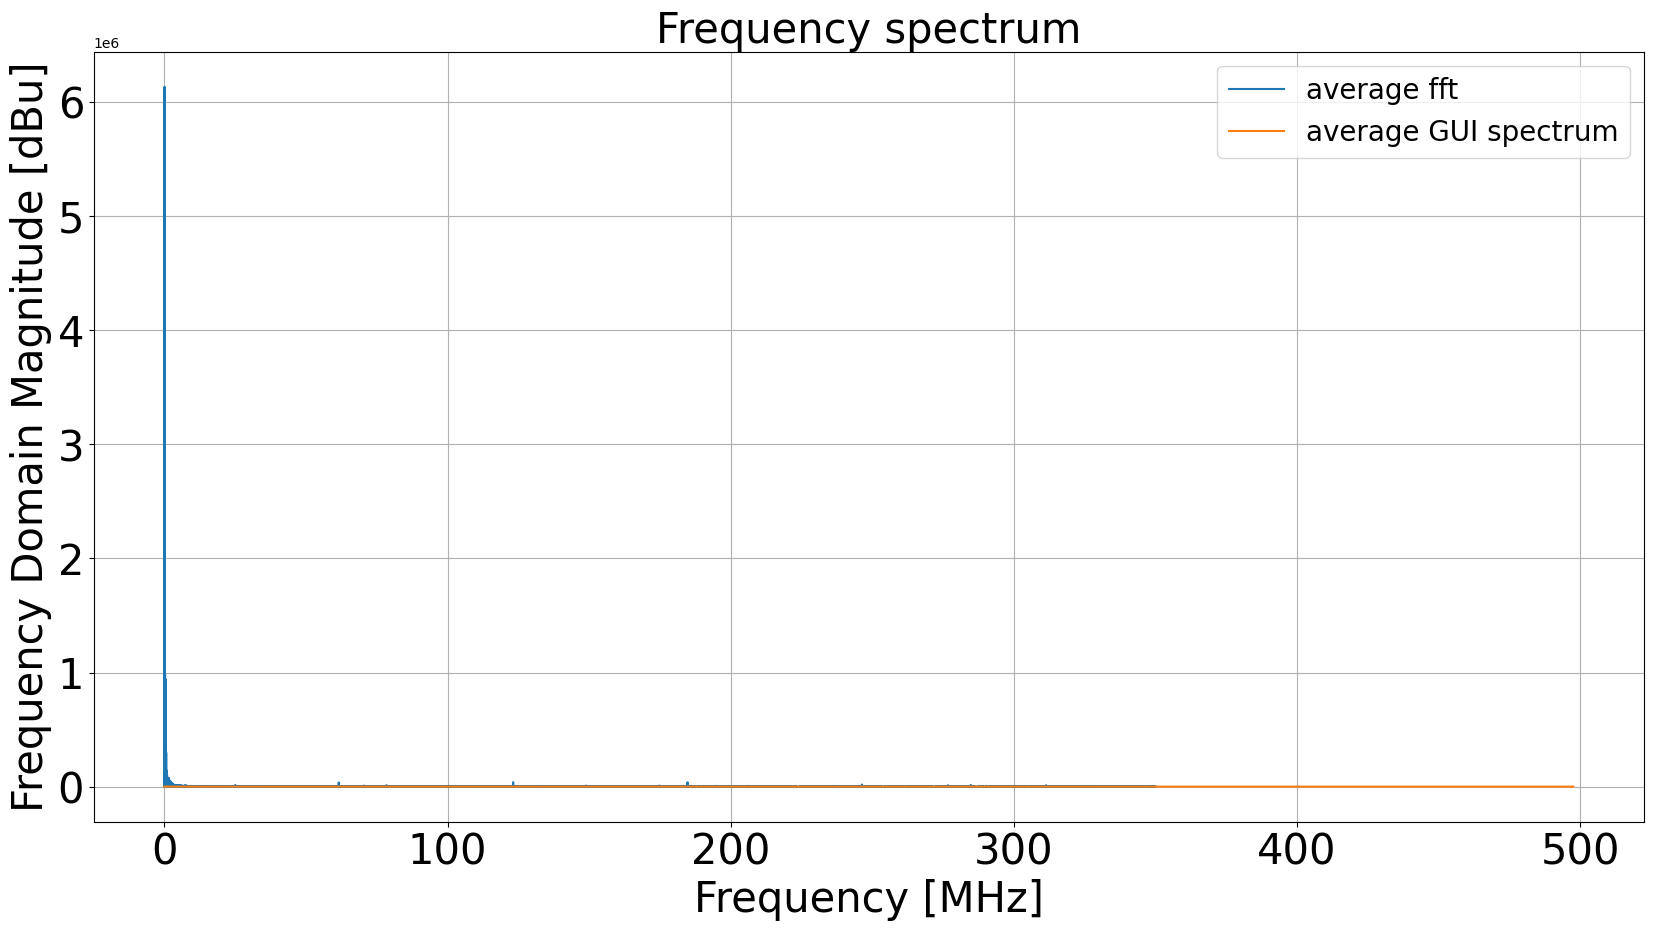

In [87]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, magnitudes, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs[freqs <= 350], magnitudes_avg[freqs <= 350] - diff, label = 'average fft')
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#-----------------------------------------------------------------------------

#plt.errorbar(freqs, magnitudes, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_GUI, magnitudes_avg_GUI, label = 'average GUI spectrum')
plt.legend(fontsize = 20)
#plt.semilogx()

#plt.savefig("070824_15.46/avg_fft_vs_gui_B.png", format = "png", bbox_inches = "tight")
#plt.savefig("070824_15.46/avg_fft_vs_gui_B.pdf", format = "pdf", bbox_inches = "tight")
plt.show()